In [1]:
%load_ext autoreload
%autoreload 2

In [191]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from spot_gl.spot_basic import *
from spot_gl.spot_arm import *
from spot_gl.spot_graph_nav import *
from spot_gl.gl_functions import *

In [3]:
# sdk, robot, id_client, \
# robot_state_client, command_client, \
# image_client, graph_nav_client, \
# world_object_client, manipulation_api_client = init_robot('192.168.50.3')

In [4]:
# lease_client, lease, lease_keep_alive = get_lease(robot)

In [5]:
# Initialize Groundlight API
gl = gl_init()
detectors = gl.list_detectors()

chair_stem_det = detectors.results[0]
hand_raise_det = detectors.results[2]

In [455]:
get_batt_info(robot_state_client)

Battery at: 8.0 %. Robot has 450 seconds left


(8.0, 450)

In [457]:
cmd = RobotCommandBuilder.battery_change_pose_command(dir_hint=1)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [198]:
success = power_on(robot)

In [456]:
bdcrc.blocking_selfright(command_client)

In [263]:
bdcrc.blocking_stand(command_client)

In [14]:
# move_robot_relative(command_client, robot, -1, -0.3, 0)

In [9]:
# upload_graph_and_snapshots(graph_nav_client, graph_upload_filepath)
# success = graph_localize_fiducial(command_client, graph_nav_client, robot_state_client, robot)
# waypoint_list = create_waypoint_list(graph_nav_client) 

# nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[14], cmd_duration = 15)
# wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)

In [15]:
def get_fid_info(world_object_client, fid_num):
    request_fiducials = [world_object_pb2.WORLD_OBJECT_APRILTAG]
    fiducial_objects = world_object_client.list_world_objects(
                object_type=request_fiducials).world_objects
    time.sleep(0.5)

    fid = None
    for fiducial_obj in fiducial_objects:
        if fiducial_obj.apriltag_properties.tag_id == fid_num:
            fid = fiducial_obj
    if fid is None:
        logging.error("COULD NOT FIND FIDUCIAL {}".format(fid_num))
        return None
    fid_tree_snapshot = fid.transforms_snapshot
    vision_tform_fid = get_a_tform_b(fid_tree_snapshot, 
                                         frame_a = 'vision', 
                                         frame_b ='filtered_fiducial_{}'.format(fid_num))
    fid_loc = {'fid_tree_snapshot': fid_tree_snapshot,
               'vision_tform_fid': vision_tform_fid}
    
    return fid_loc

In [16]:
def robot_go_to_in_fid_frame(command_client, vision_tform_fid, x, y, z):
    robot_rot = np.array([0,1,0])

    robot_rot_obj = sciRot.from_euler('xyz',np.pi/2*robot_rot)
    robot_rot_mtx = robot_rot_obj.as_matrix()
    robot_rot_quat = bdcmh.Quat.from_matrix(robot_rot_mtx)

    robot_pose_fid_frame_proto = geometry_pb2.SE3Pose(
        position = geometry_pb2.Vec3(x = x, y = y, z = z),
        rotation = robot_rot_quat.to_proto()
    )

    robot_pose_fid_frame_se3 = bdcmh.SE3Pose.from_proto(robot_pose_fid_frame_proto)

    robot_pose_vision_frame_se3 = (vision_tform_fid * robot_pose_fid_frame_se3)

    flat_robot_pose_vision_frame_se2 = bdcmh.SE2Pose.flatten(robot_pose_vision_frame_se3)
    flat_robot_pose_vision_frame_se2.to_proto()

    cmd = RobotCommandBuilder.synchro_se2_trajectory_command(
        goal_se2 = flat_robot_pose_vision_frame_se2.to_proto(), 
        frame_name = 'vision'
    )

    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    bdcrc.block_for_trajectory_cmd(command_client, cmd_id, timeout_sec = timeout_sec)

In [414]:
def hand_go_to_in_fid_frame(command_client, 
                            vision_tform_fid, x, y, z, 
                            hand_rot = np.array([0,1,0])*np.pi/2, 
                            blocking = True, follow = False):
    
    rotObj = sciRot.from_euler('xyz',hand_rot)
    rot_mtx = rotObj.as_matrix()
    rot_quat = bdcmh.Quat.from_matrix(rot_mtx)

    hand_pose_fid_frame_proto = geometry_pb2.SE3Pose(
        position = geometry_pb2.Vec3(x = x, y = y, z = z), 
        rotation = rot_quat.to_proto())

    hand_pose_fid_frame_se3 = bdcmh.SE3Pose.from_proto(hand_pose_fid_frame_proto)

    hand_pose_vision_frame_se3 = (vision_tform_fid * hand_pose_fid_frame_se3)
    
    body_cmd = RobotCommandBuilder.follow_arm_command()
    cmd = RobotCommandBuilder.arm_pose_command(x = hand_pose_vision_frame_se3.x,
                                               y = hand_pose_vision_frame_se3.y,
                                               z = hand_pose_vision_frame_se3.z,
                                               qw = hand_pose_vision_frame_se3.rotation.w,
                                               qx = hand_pose_vision_frame_se3.rotation.x,
                                               qy = hand_pose_vision_frame_se3.rotation.y,
                                               qz = hand_pose_vision_frame_se3.rotation.z,
                                               frame_name = 'vision')
    if follow:
        cmd = RobotCommandBuilder.build_synchro_command(body_cmd, cmd)

    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    
    if blocking:
        bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = timeout_sec)

In [415]:
def gripper_close_with_torque(command_client, torque):
    
    """torque can range from 0-16.25 N*m"""
    # robot_state = robot_state_client.get_robot_state()
    # print(robot_state.kinematic_state.joint_states[-1].load)
    gripper_traj_point = trajectory_pb2.ScalarTrajectoryPoint(point = 0)

    gripper_traj = trajectory_pb2.ScalarTrajectory(points = [gripper_traj_point])

    claw_gripper_command = gripper_command_pb2. \
        ClawGripperCommand.Request(trajectory = gripper_traj,
                                   maximum_torque = wrappers_pb2.DoubleValue(value = torque))

    gripper_command = gripper_command_pb2. \
        GripperCommand.Request(claw_gripper_command = claw_gripper_command)

    synchronized_command = synchronized_command_pb2.SynchronizedCommand.Request(
        gripper_command = gripper_command)

    gripper_close_command = robot_command_pb2.RobotCommand(synchronized_command = synchronized_command)

    gripper_cmd_id = command_client.robot_command(gripper_close_command, 
                                              end_time_secs = time.time()+timeout_sec)

In [441]:
gripper_open(command_client)
blocking_stow(command_client)

True

In [442]:
body_orientation = bosdyn.geometry.EulerZXY(yaw = 0, roll = 0, pitch = -np.pi/4)
cmd = RobotCommandBuilder.synchro_stand_command(body_height = 0.15,
                                                footprint_R_body = body_orientation)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
time.sleep(1)

In [443]:
fid_loc_14 = get_fid_info(world_object_client, 14)
vision_tform_fid_14 = fid_loc_14['vision_tform_fid']

In [444]:
robot_go_to_in_fid_frame(command_client, vision_tform_fid_14, 
                        -0.2, 0.0, 0.6)

In [64]:
# cmd = RobotCommandBuilder.synchro_stand_command(body_height = -0.2)
# cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [445]:
hand_go_to_in_fid_frame(command_client, vision_tform_fid_14, 
                        -0.43, -0.2, 0.1, 
                        hand_rot = np.array([-0.5,0,1])*np.pi/2,
                        follow = False)

time.sleep(0.5)

In [446]:
hand_go_to_in_fid_frame(command_client, vision_tform_fid_14, 
                        -0.43, -0.2, -0.05, 
                        hand_rot = np.array([-0.5,0,1])*np.pi/2,
                        follow = False)

time.sleep(0.5)

In [447]:
hand_go_to_in_fid_frame(command_client, vision_tform_fid_14, 
                        -0.43, 0, -0.05, 
                        hand_rot = np.array([-0.5,0,1])*np.pi/2,
                        follow = False)

time.sleep(0.5)

In [450]:
gripper_close_with_torque(command_client, torque = 16.25)
time.sleep(1)
robot_state = robot_state_client.get_robot_state()
print(robot_state.kinematic_state.joint_states[-1].load)

value: 11.309733390808105



In [451]:
#def arm_drag_command(command_client):
arm_drag_command_request = basic_command_pb2.ArmDragCommand.Request()
arm_drag_command = arm_command_pb2.ArmCommand.Request(arm_drag_command = arm_drag_command_request)
synchro_arm_drag_command = synchronized_command_pb2.SynchronizedCommand.Request(
    arm_command=arm_drag_command)
arm_cmd = robot_command_pb2.RobotCommand(synchronized_command=synchro_arm_drag_command)
arm_cmd_id = command_client.robot_command(arm_cmd, end_time_secs = time.time()+timeout_sec)

In [294]:
blocking_stow(command_client)

True

In [433]:
move_robot_relative(command_client, robot, 0.2, 0.5, -np.pi/2)

In [454]:
move_robot_relative(command_client, robot, 0, 0.3, -np.pi/4)

In [145]:
arm_drag_command(command_client)

TypeError: 'Request' object is not callable

In [143]:
gripper_close(command_client)

In [13]:
prev_graph_state = graph_del_save_state(graph_nav_client, robot)

In [43]:
move_robot_relative(command_client, robot, 0, -0.3, np.pi/6)

In [30]:
move_to_and_look_at(command_client, np.array([0.8, 0, -0.2]), 
                    np.array([3, 0, -0.2]))
gripper_open(command_client)

hand_color_image, image_response = cap_hand_image(image_client, 'hand_color_image')

In [190]:
gripper_open(command_client)
blocking_stow(command_client)

False

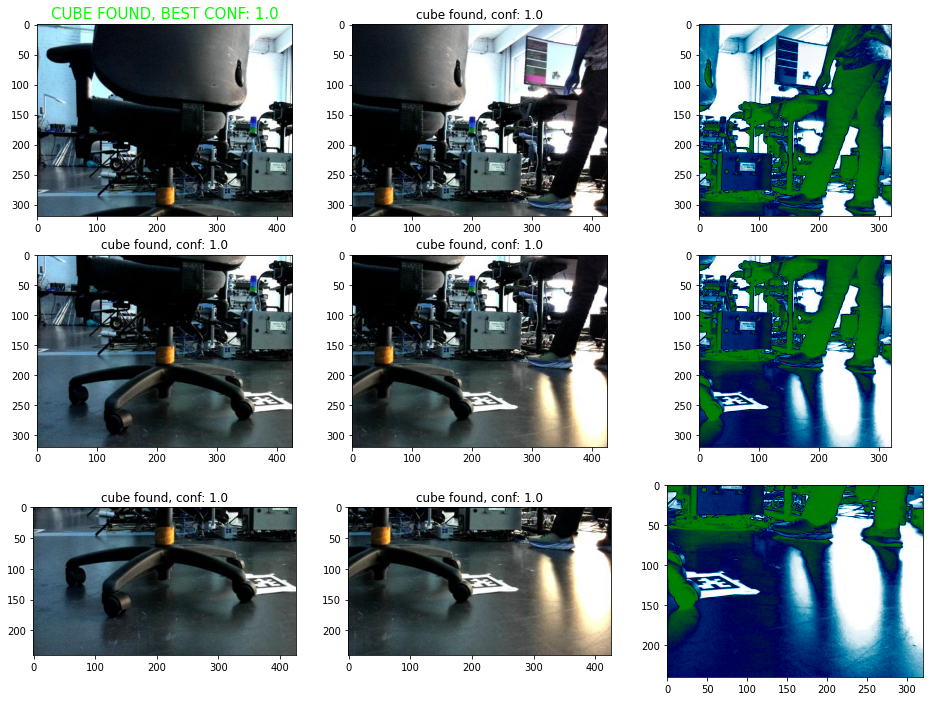

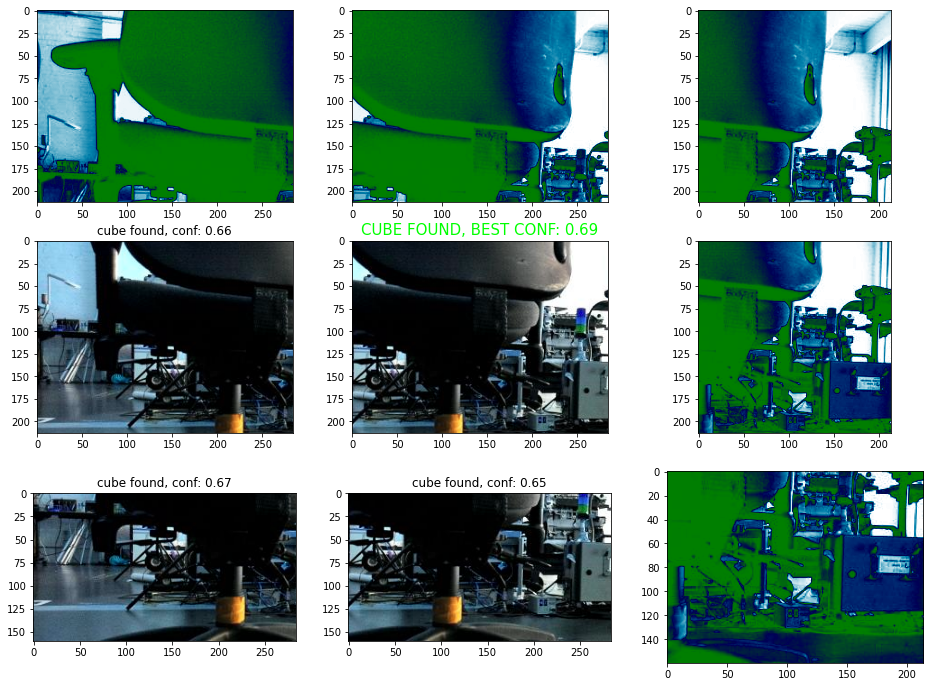

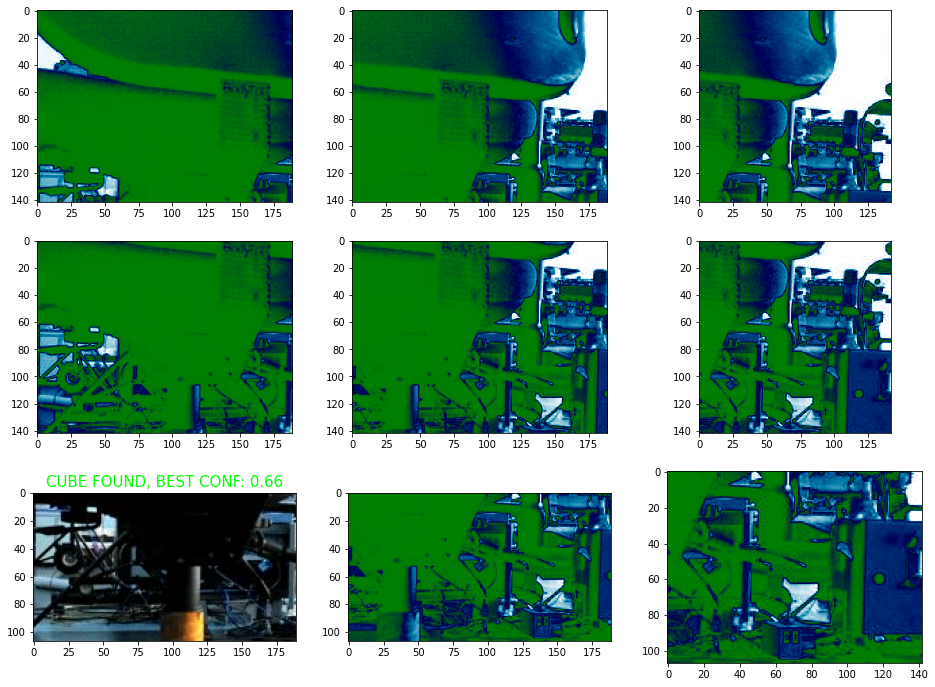

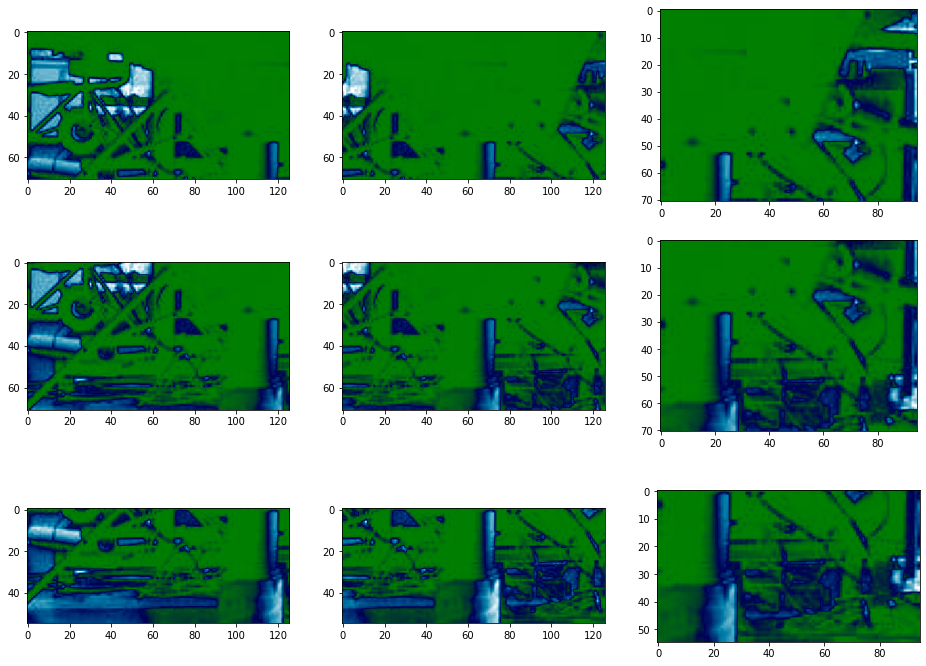

In [38]:
px_tree = sweep_localize(gl, chair_stem_det, hand_color_image, verbose = True)

In [40]:
blocking_stow(command_client)

True

In [13]:
prev_graph_state = graph_del_save_state(graph_nav_client, robot)

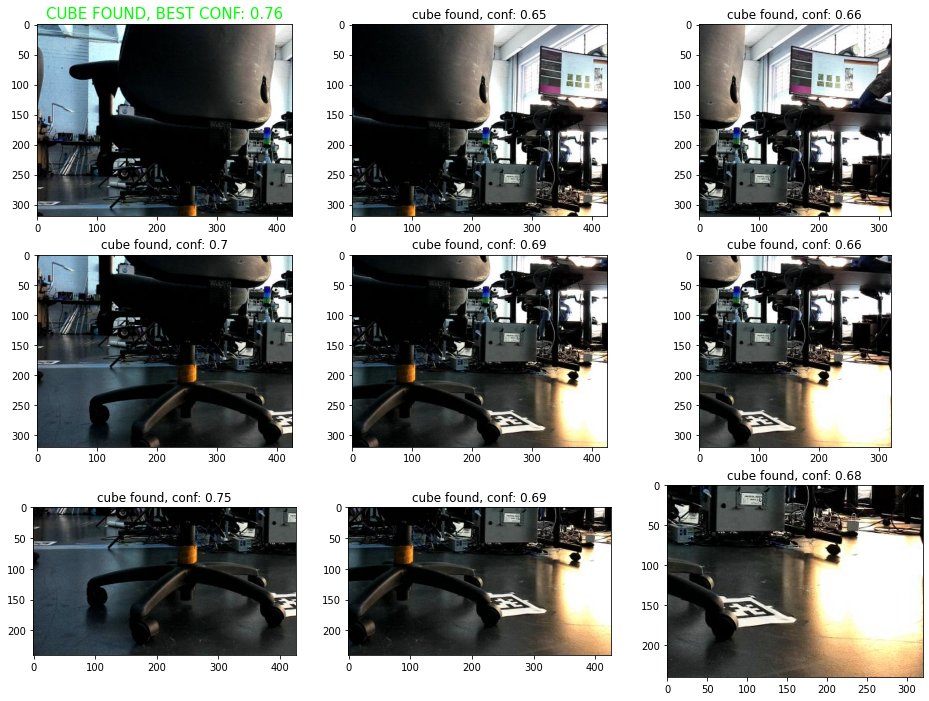

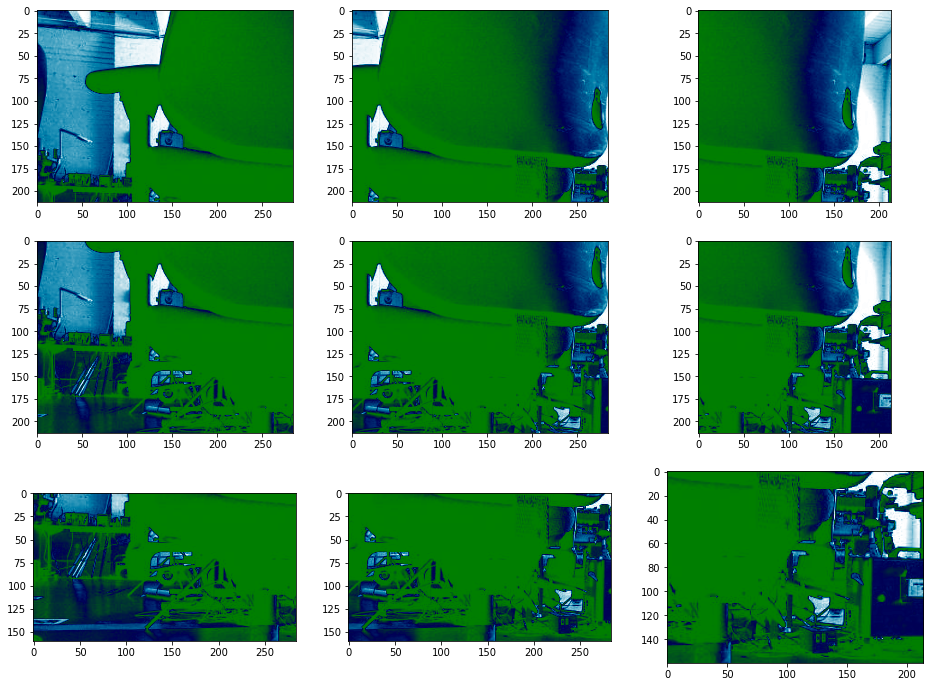

In [39]:
gripper_open(command_client)

for i in range(1):
    
    time.sleep(4)
    
    move_noise = np.random.rand(3)*0.4 - 0.2
    look_noise = np.random.rand(3)*0.5 - 0.25
    
    move_to_and_look_at(command_client, np.array([0.8, 0, -0.2]) + move_noise, 
                        np.array([3, 0, -0.2]) + look_noise)
    
    hand_color_image, image_response = cap_hand_image(image_client, 'hand_color_image')

    sweep_localize(gl, chair_stem_det, hand_color_image, verbose = True)

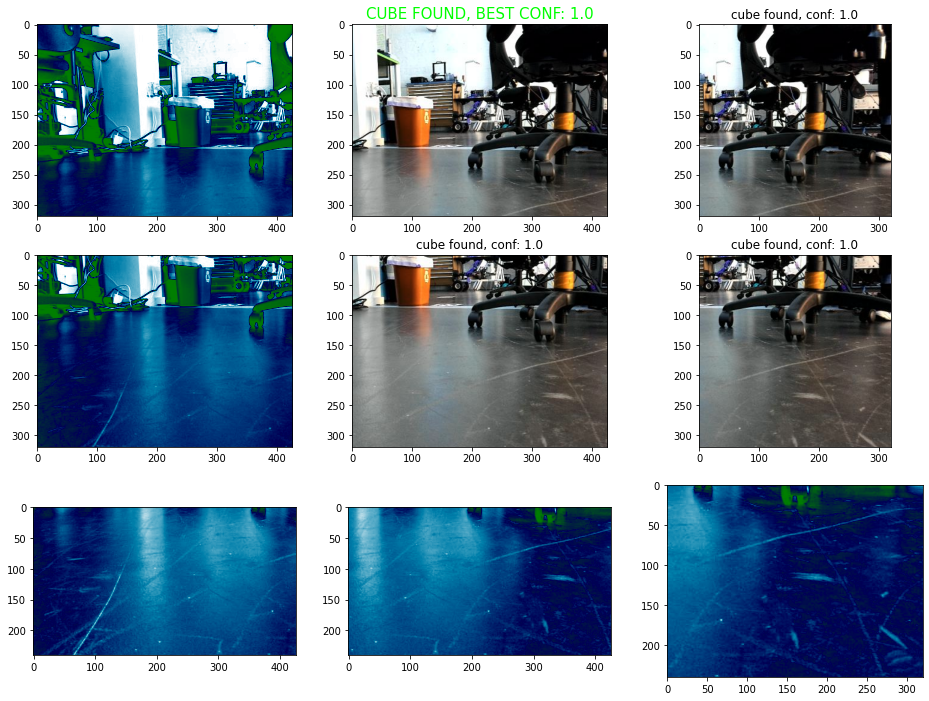

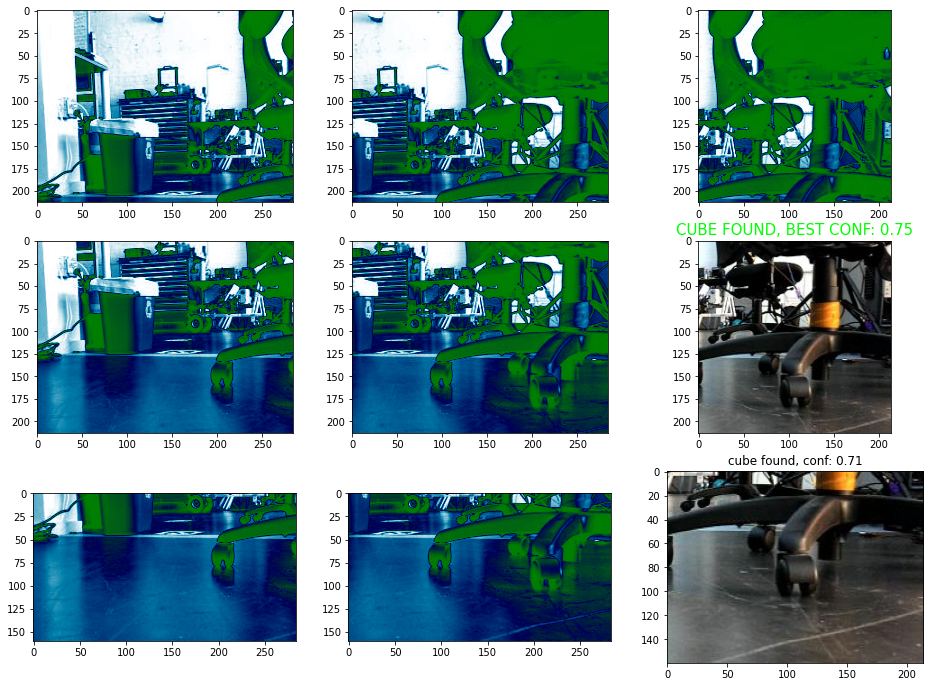

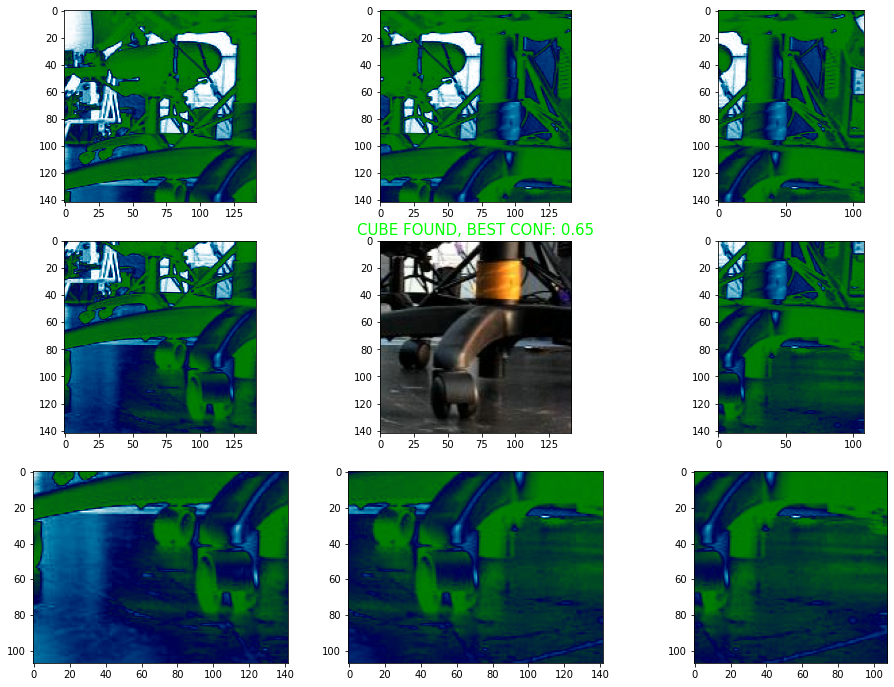

(array([160,   0]),
 array([586, 320]),
 (array([212,  80]),
  array([426, 293]),
  (array([53, 53]), array([195, 195]), None)))

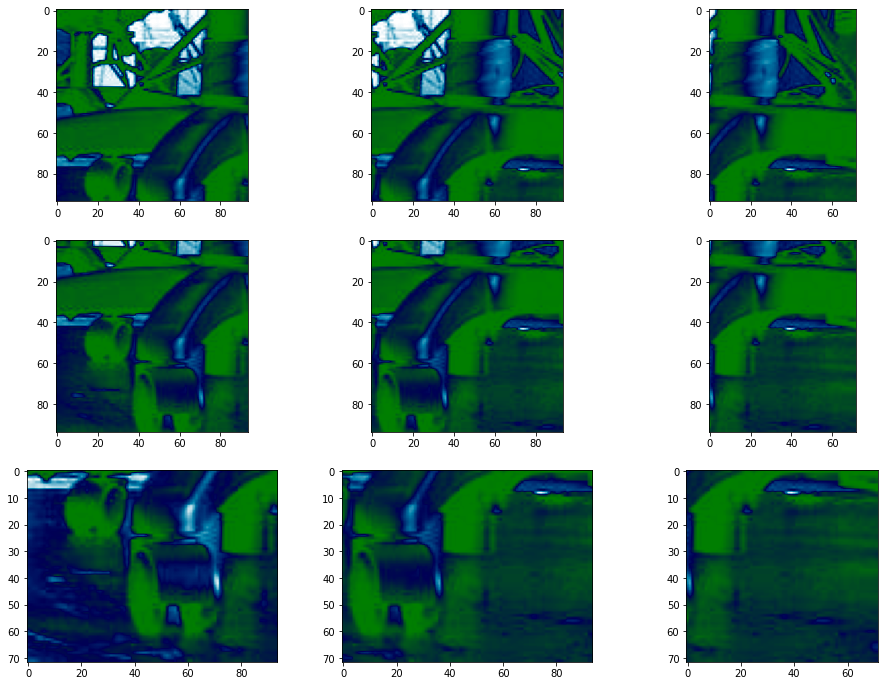

In [31]:
sweep_localize(gl, chair_stem_det, hand_color_image, verbose = True)

In [ ]:
image_query = mat_thru_det(gl, hand_raise_det, hand_color_image)

In [24]:
move_robot_relative(command_client, robot, -1, 0.5, np.pi)

In [72]:
image_query.result.label == 'PASS'

True

In [75]:
image_query.result.confidence

1.0

In [60]:
noise = np.random.rand(3)

In [62]:
noise

array([0.0195254 , 0.08607575, 0.04110535])

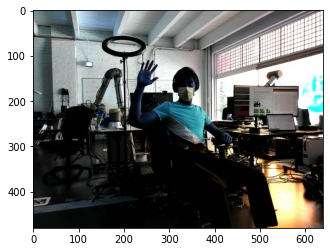

In [55]:
plt.imshow(hand_color_image)

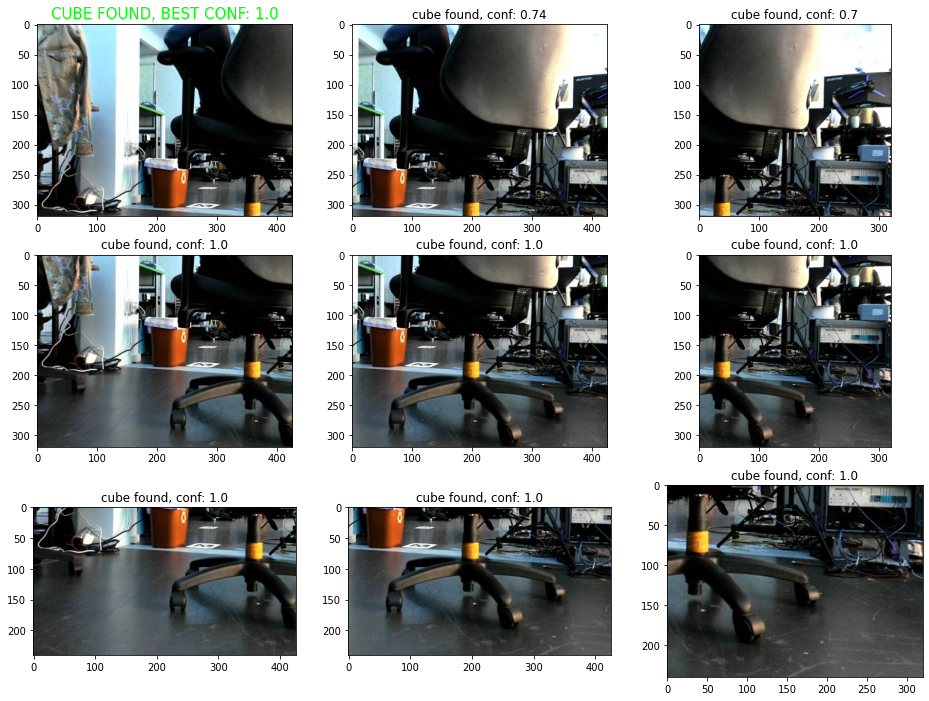

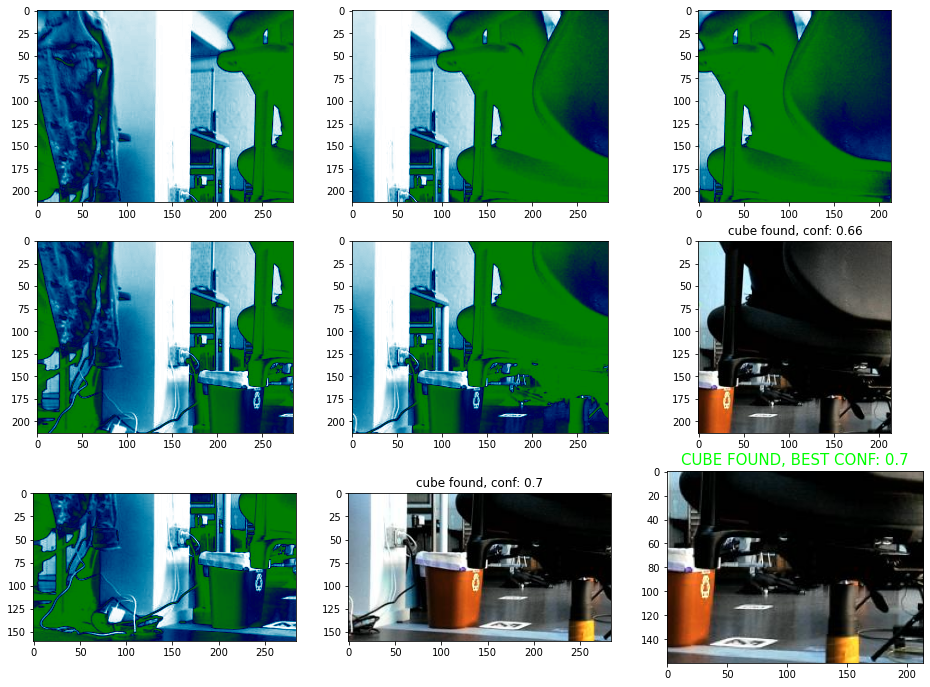

(array([0, 0]),
 array([426, 320]),
 (array([212, 160]), array([426, 320]), None))

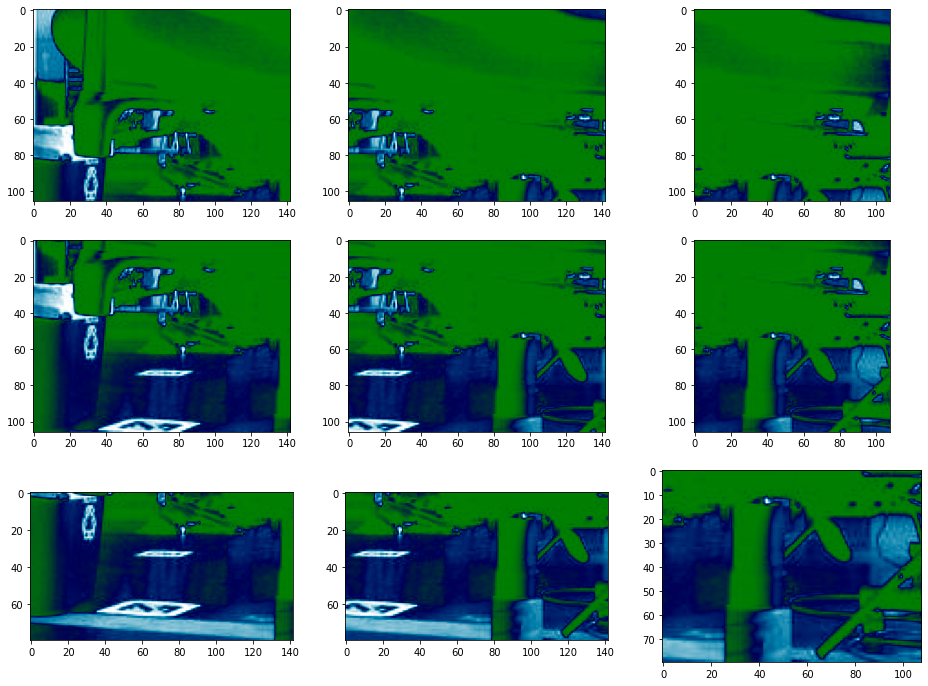

In [15]:
sweep_localize(gl, chair_stem_det, hand_color_image, verbose = True)